In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import recall_score


In [2]:
results_folder = f'../data/results/'
#file_name_full_data = 'full_data_with_failure_marking.csv' 
#file_name_full_data = 'full_data_with_failure_and_pre-fault_marking.csv'
file_name_full_data = 'full_data_with_failure_and_all_pre-fault_marking.csv'

In [3]:
df = pd.read_csv(
    results_folder + file_name_full_data,
    index_col=False,
    header = 0,
)

In [4]:
df['class'].value_counts()

class
0    42870
1     1864
2     1746
Name: count, dtype: int64

### Data Cleaning and pre-processing

In [6]:
# Features to consider
columns =  ['min', 'max', 'std', 'kurtosis', 'rms', 'skew', 'shannon_entropy']

In [7]:
df[columns].head()

,min,max,std,kurtosis,rms,skew,shannon_entropy
0,-0.183,0.029,0.072865,1.069163,0.124614,-0.029993,4.901797
1,-0.132,-0.068,0.025988,1.161552,0.123811,-0.070075,4.879316
2,-0.244,-0.044,0.067978,0.986286,0.125246,-0.041646,4.889290
3,-0.139,-0.017,0.046380,1.034294,0.125197,0.005162,4.897318
4,-0.227,-0.027,0.066552,1.110164,0.125618,-0.060196,4.912317


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46480 entries, 0 to 46479
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             46480 non-null  object 
 1   channel          46480 non-null  int64  
 2   min              46480 non-null  float64
 3   max              46480 non-null  float64
 4   std              46480 non-null  float64
 5   kurtosis         46475 non-null  float64
 6   shannon_entropy  46480 non-null  float64
 7   skew             46475 non-null  float64
 8   rms              46480 non-null  float64
 9   test             46480 non-null  int64  
 10  id               46480 non-null  object 
 11  class            46480 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 4.3+ MB


In [9]:
df[df.isna().any(axis=1)]

,time,channel,min,max,std,kurtosis,shannon_entropy,skew,rms,test,id,class
7114,2003-11-08 20:01:44,4,-0.149,0.022,0.059444,NaN,4.878939,NaN,0.140450,1,1_4_2003-11-08 20:01:44,0
9270,2003-11-08 20:01:44,5,-0.183,-0.007,0.067377,NaN,5.203651,NaN,0.158153,1,1_5_2003-11-08 20:01:44,0
11426,2003-11-08 20:01:44,6,-0.225,-0.039,0.071406,NaN,5.235471,NaN,0.161812,1,1_6_2003-11-08 20:01:44,0
13582,2003-11-08 20:01:44,7,-0.234,-0.039,0.062489,NaN,4.780331,NaN,0.134131,1,1_7_2003-11-08 20:01:44,0
15738,2003-11-08 20:01:44,8,-0.237,-0.063,0.064441,NaN,4.877073,NaN,0.139427,1,1_8_2003-11-08 20:01:44,0


Looks like 5 values for the stats have a NaN, since that's a small proportion of the ~46K values, we can drop them.

In [11]:
# Drop any NaNs
df.dropna(inplace = True)

### Target Variable

`class = 0` is negative class - i.e. no problem in the machinery.

`class = 1` is the positive class - i.e. problem is detected.

`class = 2` is another positive class - pre-fault detection state.

In [13]:
df['class'].value_counts(normalize=True)

class
0    0.922324
1    0.040108
2    0.037569
Name: proportion, dtype: float64

We note that we have a mismatched class - we will review later whether to pursue different strategies to resolve it.

In [15]:
# Features that are relevant to classification - we ignore those related to time, & test artifacts such as 
#   id, channel and test #
features_to_scale = df.drop(columns=['time', 'id', 'test', 'channel']).columns.tolist()  

In [16]:
X = df[features_to_scale].drop(columns = ['class'])

In [17]:
y = df['class']

In [18]:
X.head()

,min,max,std,kurtosis,shannon_entropy,skew,rms
0,-0.183,0.029,0.072865,1.069163,4.901797,-0.029993,0.124614
1,-0.132,-0.068,0.025988,1.161552,4.879316,-0.070075,0.123811
2,-0.244,-0.044,0.067978,0.986286,4.889290,-0.041646,0.125246
3,-0.139,-0.017,0.046380,1.034294,4.897318,0.005162,0.125197
4,-0.227,-0.027,0.066552,1.110164,4.912317,-0.060196,0.125618


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3,
    shuffle=True,
    random_state = 123,
)

## Preprocessing complete

### Ensemble Technique - RandomForestClassifier

In [36]:
rfc_classifier = RandomForestClassifier()

In [38]:
# Create the pipeline
rfc_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('classifier', rfc_classifier)
])

In [ ]:
rfc_classifier = RandomForestClassifier(
    criterion = 'gini',
    max_depth = 30, 
    max_features = 'log2',
    min_samples_split = 2, 
    n_estimators = 100 ,
)

In [ ]:
rfc_pipeline.fit(X_train, y_train)

In [ ]:
rfc_y_pred_probs = rfc_pipeline.predict_proba(X_test)

#### GridSearch to get the best parameters

In [40]:
# Set up the parameter grid
rfc_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
}


In [42]:
# Initialize GridSearchCV
rfc_grid_search = GridSearchCV(
    estimator = rfc_pipeline, 
    param_grid = rfc_param_grid, 
    cv=3, 
    n_jobs=-1, 
    verbose=3,
)

In [44]:
# Fit the model
rfc_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             verbose=3)

In [ ]:
np.sum(rfc_grid_search.cv_results_['mean_fit_time'])

In [46]:
rfc_grid_search.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 30,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 100}

In [ ]:
rfc_best_estimator_y_preds = rfc_grid_search.best_estimator_.predict(X_test)

In [ ]:
print(classification_report(y_test, rfc_best_estimator_y_preds, zero_division=0.0))

In [ ]:
rfc_fine_tuned_best_estimator_cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    rfc_best_estimator_y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

### Using probabilities to classify 

In [48]:
def get_predictions_from_probs_multiclass(probabilities, threshold=0.5):
    """
    Convert predicted probabilities to class labels based on a threshold for multi-class classification.

    Parameters:
    probabilities (np.ndarray): Array of predicted probabilities for each class.
    threshold (float): The threshold for classifying a sample as positive. 
                       Should be between 0.50 and 0.90.

    Returns:
    np.ndarray: Array of predicted class labels.
    """
    if not (0.50 <= threshold <= 0.99):
        raise ValueError("Threshold must be between 0.50 and 0.99")

    # Initialize an array to hold the predicted class labels
    predictions = np.full(probabilities.shape[0], 2)  # 2 (-1) indicates no class assigned

    # Iterate over each sample
    for i in range(probabilities.shape[0]):
        # Get the probabilities for the current sample
        class_probs = probabilities[i]
        
        # Find the classes that meet or exceed the threshold
        valid_classes = np.where(class_probs >= threshold)[0]
        
        if valid_classes.size > 0:
            # If there are valid classes, assign the class with the highest probability
            predictions[i] = valid_classes[np.argmax(class_probs[valid_classes])]
    
    return predictions

In [50]:
def find_best_threshold(y_test, y_pred_prob, positive_labels=[1]):
    """
    Find the best threshold for maximizing recall score for given positive class labels.

    Parameters:
    - y_test: array-like, true labels
    - y_pred_prob: array-like, predicted probabilities from a classifier
    - positive_labels: list, optional, positive class labels to consider for recall calculation (default is [1])

    Returns:
    - best_threshold: float, the threshold that maximizes recall for the specified positive classes

    Raises:
    - ValueError: if y_test and y_pred_prob have different lengths or if they are not valid arrays
    - TypeError: if positive_labels is not a list
    """
    
    # Error checks
    if not isinstance(y_test, (list, np.ndarray, pd.Series)):
        raise ValueError("y_test must be a list or numpy array.")
    if not isinstance(y_pred_prob, (list, np.ndarray)):
        raise ValueError("y_pred_prob must be a list or numpy array.")
    if len(y_test) != len(y_pred_prob):
        raise ValueError("y_test and y_pred_prob must have the same length.")
    if not isinstance(positive_labels, list):
        raise TypeError("positive_labels must be a list.")
    
    # Initialize lists to store recall scores and corresponding thresholds
    recall_scores = []
    thresholds = []

    # Loop through threshold values from 0.55 to 0.95 in increments of 0.05
    for threshold in [round(x, 2) for x in np.arange(0.55, 1.0, 0.05)]:
        # Get predictions using the current threshold
        y_preds = get_predictions_from_probs_multiclass(y_pred_prob, threshold)
        
        # Calculate the recall score for the specified positive classes
        recall = recall_score(y_test, y_preds, labels=positive_labels, average='weighted')
        recall_scores.append(recall)
        thresholds.append(threshold)

    # Find the best threshold that maximizes recall
    best_threshold = thresholds[np.argmax(recall_scores)]
    
    return best_threshold

In [52]:
rfc_y_pred_probs = rfc_grid_search.best_estimator_.predict_proba(X_test)

In [54]:
rfc_best_threshold = find_best_threshold(y_test, rfc_y_pred_probs, positive_labels=[1,2])

In [ ]:
rfc_best_threshold

In [56]:
rfc_proba_y_preds = get_predictions_from_probs_multiclass(rfc_y_pred_probs, rfc_best_threshold)

In [58]:
rep = classification_report(y_test, rfc_proba_y_preds, zero_division=0.0)
print(rep)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     12861
           1       0.99      0.85      0.91       548
           2       0.54      0.87      0.67       534

    accuracy                           0.97     13943
   macro avg       0.84      0.90      0.86     13943
weighted avg       0.98      0.97      0.97     13943



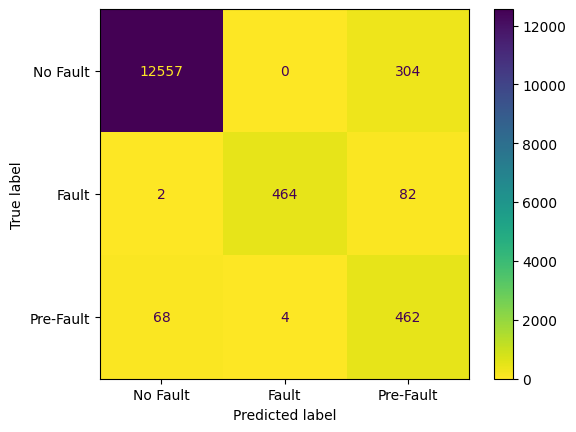

In [64]:
rfc_fine_tuned_best_threshold_cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    rfc_proba_y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

In [66]:
rfc_fine_tuned_best_threshold_cm_display.figure_.savefig('../images/rfc_fine_tuned_conf_matrix.png', dpi=300)

In [ ]:
import joblib

joblib.dump(rfc_grid_search.best_estimator_, 'rfc_fine_tuned_failure_prediction')

### Ensemble Technique - XGBoost - 

In [68]:
bst = OneVsRestClassifier(
    XGBClassifier(
        num_class = 3,
        objective='multi:softprob',
    )
)

In [70]:
# Create the pipeline
xgb_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('classifier', bst)
])

In [72]:
# Define the parameter grid
xgb_param_grid = {
    'classifier__estimator__n_estimators': [100, 200, 300, 400],  # Number of trees
    'classifier__estimator__max_depth': [5, 10, 15],  # Maximum depth of trees
    'classifier__estimator__learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'classifier__estimator__subsample': [0.6, 0.8, 1.0],  # Proportion of samples used for training each tree
}

In [74]:
# Create the GridSearchCV object
xgb_grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    scoring='accuracy',  
    cv=3,  # Number of cross-validation folds
    verbose=3,  # Controls the verbosity of the output
    n_jobs=-1  # Use all available cores
)


In [76]:
xgb_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('classifier',
                                        OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                                                    booster=None,
                                                                                    callbacks=None,
                                                                                    colsample_bylevel=None,
                                                                                    colsample_bynode=None,
                                                                                    colsample_bytree=None,
                                                                                    device=None,
                                                                                    early_stopping_rounds=None,
                                                                                    enable_categorical=False,
                                                                                    eval_metric=None,
                                                                                    feature_types=None,
                                                                                    gamma=Non...
                                                                                    multi_strategy=None,
                                                                                    n_estimators=None,
                                                                                    n_jobs=None,
                                                                                    num_class=3,
                                                                                    num_parallel_tree=None, ...)))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__learning_rate': [0.01, 0.1,
                                                                  0.2],
                         'classifier__estimator__max_depth': [5, 10, 15],
                         'classifier__estimator__n_estimators': [100, 200, 300,
                                                                 400],
                         'classifier__estimator__subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=3)

In [78]:
xgb_grid_search.best_params_

{'classifier__estimator__learning_rate': 0.2,
 'classifier__estimator__max_depth': 5,
 'classifier__estimator__n_estimators': 300,
 'classifier__estimator__subsample': 1.0}

In [ ]:
xgb_best_estimator_y_preds = xgb_grid_search.best_estimator_.predict(X_test)

In [ ]:
print(classification_report(y_test, xgb_best_estimator_y_preds, zero_division=0.0))

In [ ]:
xgb_fine_tuned_best_estimator_cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    xgb_best_estimator_y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

In [80]:
xgb_y_pred_probs = xgb_grid_search.best_estimator_.predict_proba(X_test)

In [82]:
xgb_best_threshold = find_best_threshold(y_test, xgb_y_pred_probs, positive_labels=[1,2])

In [84]:
print(xgb_best_threshold)

0.9


In [86]:
xgb_proba_y_preds = get_predictions_from_probs_multiclass(xgb_y_pred_probs, xgb_best_threshold)

In [88]:
print(classification_report(y_test, xgb_proba_y_preds, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     12861
           1       0.98      0.91      0.94       548
           2       0.62      0.82      0.71       534

    accuracy                           0.97     13943
   macro avg       0.86      0.90      0.88     13943
weighted avg       0.98      0.97      0.98     13943



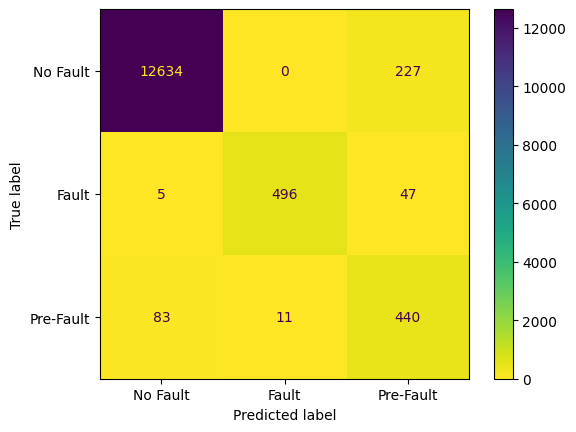

In [90]:
xgb_fine_tuned_best_threshold_cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    xgb_proba_y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

In [94]:
xgb_fine_tuned_best_threshold_cm_display.figure_.savefig('../images/xgb_fine_tuned_conf_matrix.png', dpi=300)

In [ ]:
import joblib

joblib.dump(xgb_grid_search.best_estimator_, 'xgb_fine_tuned_failure_prediction')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

fault_categories = {
    0 : 'No Fault', 
    1 : 'Fault', 
    2 : 'Pre-Fault',
}

# Assuming y_test contains the true labels and y_scores contains the predicted probabilities for each class
y_scores = rfc_y_pred_probs  # xgb_y_pred_probs  # Get probabilities for all classes

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'orange']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve for {0} class (AUC = {1:0.2f})'.format(fault_categories[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.grid()
#plt.savefig('../images/ROC_XGBoost_fine_tuned_model.png', dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

fault_categories = {
    0: 'No Fault', 
    1: 'Fault', 
    2: 'Pre-Fault',
}

# Assuming y_scores is the output of predict_proba for a multiclass problem
y_scores = rfc_pipeline.predict_proba(X_test)

# Calculate precision-recall curve for each class
for i in range(len(fault_categories)):
    precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])  # Binary format for each class
    auc_pr = auc(recall, precision)
    
    # Plotting the precision-recall curve for each class
    plt.plot(recall, precision, label=f'{fault_categories[i]} Class (AUC-PR = {auc_pr:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.savefig('../images/P-R_Curve_RFC_fine_tuned_model.png', dpi=300)
plt.show()